# **Exercise 2: Estimate EPC counterfactuals under retrofit actions**

## Overview

In Exercise 1, we built descriptive models to understand which building characteristics are most associated with EPC performance. Here, we implement a simple *counterfactual (“what‑if”) analysis*:

1. Fit a model that approximates the EPC current energy efficiency score (`CURRENT_ENERGY_EFFICIENCY`) from a set of features.
2. Apply retrofit actions on a hold‑out set by changing EPC input variables (e.g., wall efficiency band), and predict the counterfactual EPC score.

> **Note**: This does *not* predict realised post‑retrofit bills. It estimates how the EPC score would change under modified building characteristics, using a data‑driven approximation of the EPC calculation logic.


## Set up

Load libraries and the EPC dataset. As in Exercise 1, we drop columns with missing values for simplicity (you can revisit this and use imputation later). The target (outcome) variable is `CURRENT_ENERGY_EFFICIENCY`. To avoid data leakage, be careful not to use any EPC output variables as predictors.

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression

# Plot defaults
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (10, 3)

def accuracy_metrics(actual, predictions):
    ''' Estimate predictive accuracy metrics '''
    actual_copy = actual.copy().reshape(-1,1)
    predictions_copy = predictions.copy().reshape(-1,1)
    
    error = actual_copy - predictions_copy    
    assert(error.shape[0] == len(actual_copy))
    if error.ndim > 1:        
        assert(error.shape[1] == 1)

    mse = np.square(error).mean()
    rmse = np.sqrt( mse )
    mae = np.abs(error).mean()
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    return rmse, mae

In [9]:
# load data
# Update path to your local folder containing certificates.csv
path = r'C:\Users\ucbva19\Git projects\BENV0092\data raw\epc-certificates-Islington'
df = pd.read_csv(f"{path}\\certificates.csv")  # change path

print(df.head())
print(df.isna().sum())

# For simplicity, drop columns with any NaNs (you can improve this later)
df = df.dropna(axis=1)

print(df.shape)
display(df.head(3))

assert(df.isna().sum().sum() == 0)

                                             LMK_KEY          ADDRESS1  \
0  05a4e13c8f8892b40f457e58195271839c253e738b2a4a...            Flat A   
1  07c0c456133427557a94e545821381d14767982acbf6cb...           Flat 17   
2  09ff1f899a2a4bfa4b183664b5d95962f6f636beba7616...           Flat 13   
3  104aed0a570454905c714411fff45406314dbb0cdcbf92...  144a Hanley Road   
4  117e6ac108ca5cb9de1ac1c4f5c82f526f8a6f7be28bf9...           Flat 16   

                  ADDRESS2            ADDRESS3 POSTCODE  \
0           32 Hanley Road                 NaN   N4 3DR   
1  Park Gate House 250-252  Seven Sisters Road   N4 2HU   
2  Park Gate House 250-252  Seven Sisters Road   N4 2HU   
3                      NaN                 NaN   N4 3DW   
4  Park Gate House 250-252  Seven Sisters Road   N4 2HU   

   BUILDING_REFERENCE_NUMBER CURRENT_ENERGY_RATING POTENTIAL_ENERGY_RATING  \
0                10008499045                     D                       C   
1                10003804896                

,LMK_KEY,ADDRESS1,POSTCODE,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,PROPERTY_TYPE,BUILT_FORM,...,LIGHTING_ENV_EFF,WIND_TURBINE_COUNT,FLOOR_HEIGHT,ADDRESS,LOCAL_AUTHORITY_LABEL,CONSTRUCTION_AGE_BAND,LODGEMENT_DATETIME,TENURE,FIXED_LIGHTING_OUTLETS_COUNT,REPORT_TYPE
0,05a4e13c8f8892b40f457e58195271839c253e738b2a4a...,Flat A,N4 3DR,10008499045,D,C,68,77,Flat,Not Recorded,...,Good,0,2.86,"Flat A, 32 Hanley Road",Islington,England and Wales: 1900-1929,2025-11-30 22:21:53,Rented (social),10,100
1,07c0c456133427557a94e545821381d14767982acbf6cb...,Flat 17,N4 2HU,10003804896,B,B,82,82,Flat,Not Recorded,...,Good,0,2.30,"Flat 17, Park Gate House 250-252, Seven Sister...",Islington,England and Wales: 2003-2006,2025-11-30 20:48:23,Owner-occupied,6,100
2,09ff1f899a2a4bfa4b183664b5d95962f6f636beba7616...,Flat 13,N4 2HU,10007227906,B,B,84,84,Flat,Not Recorded,...,Good,0,2.30,"Flat 13, Park Gate House 250-252, Seven Sister...",Islington,England and Wales: 2003-2006,2025-11-30 20:47:40,Owner-occupied,6,100


## Fit Predictive Models

First, we train two predictive models and select the best one. As in Exercise 1, features should be based on building characteristics (geometry, built form, efficiency bands for fabric, heating, etc.), whereas EPC outputs (costs, energy consumption, ratings) should *not* be used as features. 

In [3]:
target_variable = 'CURRENT_ENERGY_EFFICIENCY'

# further separate features into numerical, categorical, and ordinal
numerical_features = ['TOTAL_FLOOR_AREA', 'FIXED_LIGHTING_OUTLETS_COUNT', 'LOW_ENERGY_LIGHTING']
ordinal_features = ['WALLS_ENERGY_EFF', 'MAINHEAT_ENERGY_EFF', 'LIGHTING_ENERGY_EFF', 'HOT_WATER_ENERGY_EFF', 'WINDOWS_ENERGY_EFF']
categorical_features = ['PROPERTY_TYPE', 'BUILT_FORM']

feature_list = numerical_features + ordinal_features + categorical_features

Y = df[target_variable]
X = df[feature_list]

# Training/ test split
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.33, random_state=42)

# Preprocessing
categories_list = [df['PROPERTY_TYPE'].unique(), df['BUILT_FORM'].unique()]

ord_list =   [['Very Poor', 'Poor', 'Average', 'Good', 'Very Good'] for feat in ordinal_features]

# create a preprocessor that implements one-hot and ordinal encoding
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
                  ("ord", OrdinalEncoder(categories = ord_list), ordinal_features),
                  ("num", "passthrough", numerical_features),])

We compare two models, namely, linear regression and extremely randomized trees (ExtraTrees).

In [4]:
# Model 1: Linear Regression
lr_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", LinearRegression()),
    ]
)

# Model 2: ExtraTrees
et_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", ExtraTreesRegressor(
            n_estimators=500, random_state=42, n_jobs=-1))])

lr_model.fit(train_X, train_Y)
et_model.fit(train_X, train_Y)

pred_lr = lr_model.predict(test_X)
pred_et = et_model.predict(test_X)

print('Accuracy metrics LR')
rmse_lr, mae_lr = accuracy_metrics(test_Y.values, pred_lr)

print('Accuracy metrics ET')
rmse_et, mae_et = accuracy_metrics(test_Y.values, pred_et)

# Select the model with lower RMSE
model = et_model if mae_et <= mae_lr else lr_model
print("Selected model:", type(model.named_steps['regressor']).__name__)

Accuracy metrics LR
MSE: 32.1814364402253
RMSE: 5.672868449049854
MAE: 4.284020942917015
Accuracy metrics ET
MSE: 34.231407692187005
RMSE: 5.850761291677093
MAE: 4.020642464296644
Selected model: ExtraTreesRegressor


## Define retrofit actions (monotonic upgrades)

We model retrofit actions by **upgrading efficiency bands** in a *monotonic* way.

- A dwelling is *eligible* for an action if it is **below** the target band.
- If the dwelling is already at or above the target, the action has **no effect**.

This keeps counterfactuals sane (e.g., we never “downgrade” a building).


In [5]:
# Helper: upgrade a single ordinal feature to at least a target level

EFF_ORDER = {"Very Poor": 1,
             "Poor": 2,
             "Average": 3,
             "Good": 4,
             "Very Good": 5}

def upgrade_to_level(df_in, feature, target_level, order = EFF_ORDER):
    df_out = df_in.copy()
    idx_map = {v: i for i, v in enumerate(order)}

    current = df_out[feature].astype(str)
    current_idx = current.map(idx_map)
    target_idx = idx_map[target_level]

    eligible = current_idx < target_idx
    df_out.loc[eligible, feature] = target_level
    return df_out, eligible

# Define retrofit actions (single-feature and multi-feature)
actions = {
    "Upgrade lighting to Very Good": {
        "LIGHTING_ENERGY_EFF": "Very Good",
    },
    "Upgrade walls to Good": {
        "WALLS_ENERGY_EFF": "Good",
    },
    "Upgrade windows to Good": {
        "WINDOWS_ENERGY_EFF": "Good",
    },
    "Upgrade main heating to Very Good": {
        "MAINHEAT_ENERGY_EFF": "Very Good",
    },
    "Upgrade hot water to Good": {
        "HOT_WATER_ENERGY_EFF": "Good",
    },
    "Package: fabric + heating": {
        "WALLS_ENERGY_EFF": "Good",
        "WINDOWS_ENERGY_EFF": "Good",
        "MAINHEAT_ENERGY_EFF": "Very Good",
    },
}

list(actions.keys())


['Upgrade lighting to Very Good',
 'Upgrade walls to Good',
 'Upgrade windows to Good',
 'Upgrade main heating to Very Good',
 'Upgrade hot water to Good',
 'Package: fabric + heating']

## Predict counterfactual EPC scores on hold‑out set

For each action, we implement the following steps:
1. Predict baseline EPC score on the hold‑out set.
2. Apply the selected action (only improving eligible dwellings).
3. Predict the counterfactual EPC score.
4. Compute $\Delta \,\text{score} = \text{counterfactual} − \text{baseline}$.

Positive $\Delta$ means the retrofit improves EPC score. Clearly, we anticipate that $\Delta$ will be positive in most cases, although counterintuitive results are plausible.

In [6]:
# Baseline predictions on holdout
baseline_pred = model.predict(test_X)

results = []
per_action_deltas = {}  # store arrays for plotting

# Iterate over potential actions
for action_name, changes in actions.items():
    X_cf = test_X.copy()
    eligible_mask = np.ones(len(X_cf), dtype=bool)

    print(f'Action: {action_name}')
    
    # Apply each feature upgrade; eligibility is the AND across features
    for feat, target_level in changes.items():
        X_cf, elig = upgrade_to_level(X_cf, feat, target_level)
        eligible_mask &= elig.values

    # Predict counterfactuals
    cf_pred = model.predict(X_cf)

    delta = cf_pred - baseline_pred
    
    # Keep only eligible dwellings
    delta_eligible = delta[eligible_mask]

    results.append({
        "action": action_name,
        "eligible_n": int(eligible_mask.sum()),
        "eligible_share": float(eligible_mask.mean()),
        "mean_delta": float(np.mean(delta_eligible)) if eligible_mask.sum() else np.nan,
        "median_delta": float(np.median(delta_eligible)) if eligible_mask.sum() else np.nan,
    })

    per_action_deltas[action_name] = delta_eligible

results_df = pd.DataFrame(results).sort_values("mean_delta", ascending=False)
display(results_df)


Action: Upgrade lighting to Very Good
Action: Upgrade walls to Good
Action: Upgrade windows to Good
Action: Upgrade main heating to Very Good
Action: Upgrade hot water to Good
Action: Package: fabric + heating


,action,eligible_n,eligible_share,mean_delta,median_delta
5,Package: fabric + heating,1055,0.639394,8.603494,7.8420
1,Upgrade walls to Good,1154,0.699394,4.954624,4.2244
4,Upgrade hot water to Good,449,0.272121,3.645863,3.5840
2,Upgrade windows to Good,1424,0.863030,1.333016,1.1025
0,Upgrade lighting to Very Good,1051,0.636970,0.738254,0.3290
3,Upgrade main heating to Very Good,1640,0.993939,0.656847,0.0000


## Visualise multiple actions

We show:
- Bar chart of mean $\Delta$ score per action (eligible homes only)
- Boxplot of the full distribution of $\Delta$ score per action

Actions with zero eligible homes are excluded.

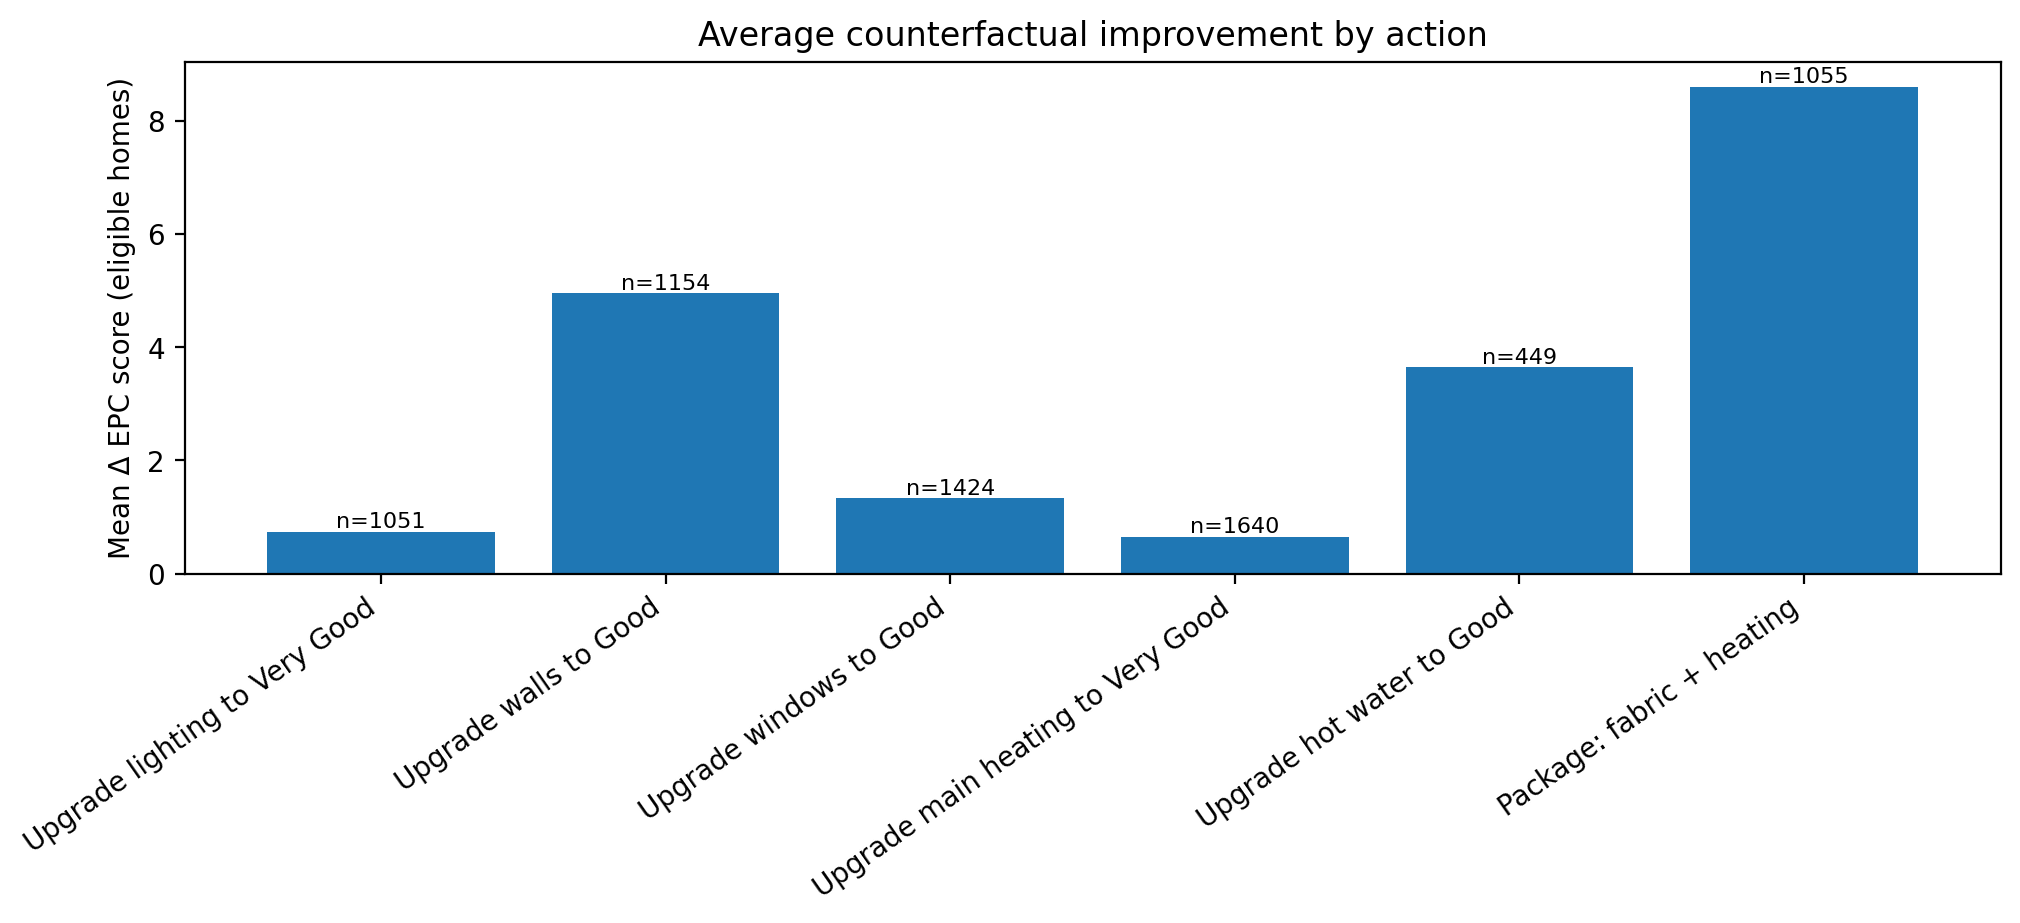

C:\Users\ucbva19\AppData\Local\Temp\ipykernel_11828\120588181.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([per_action_deltas[a] for a in plot_actions], labels=plot_actions, showfliers=False)


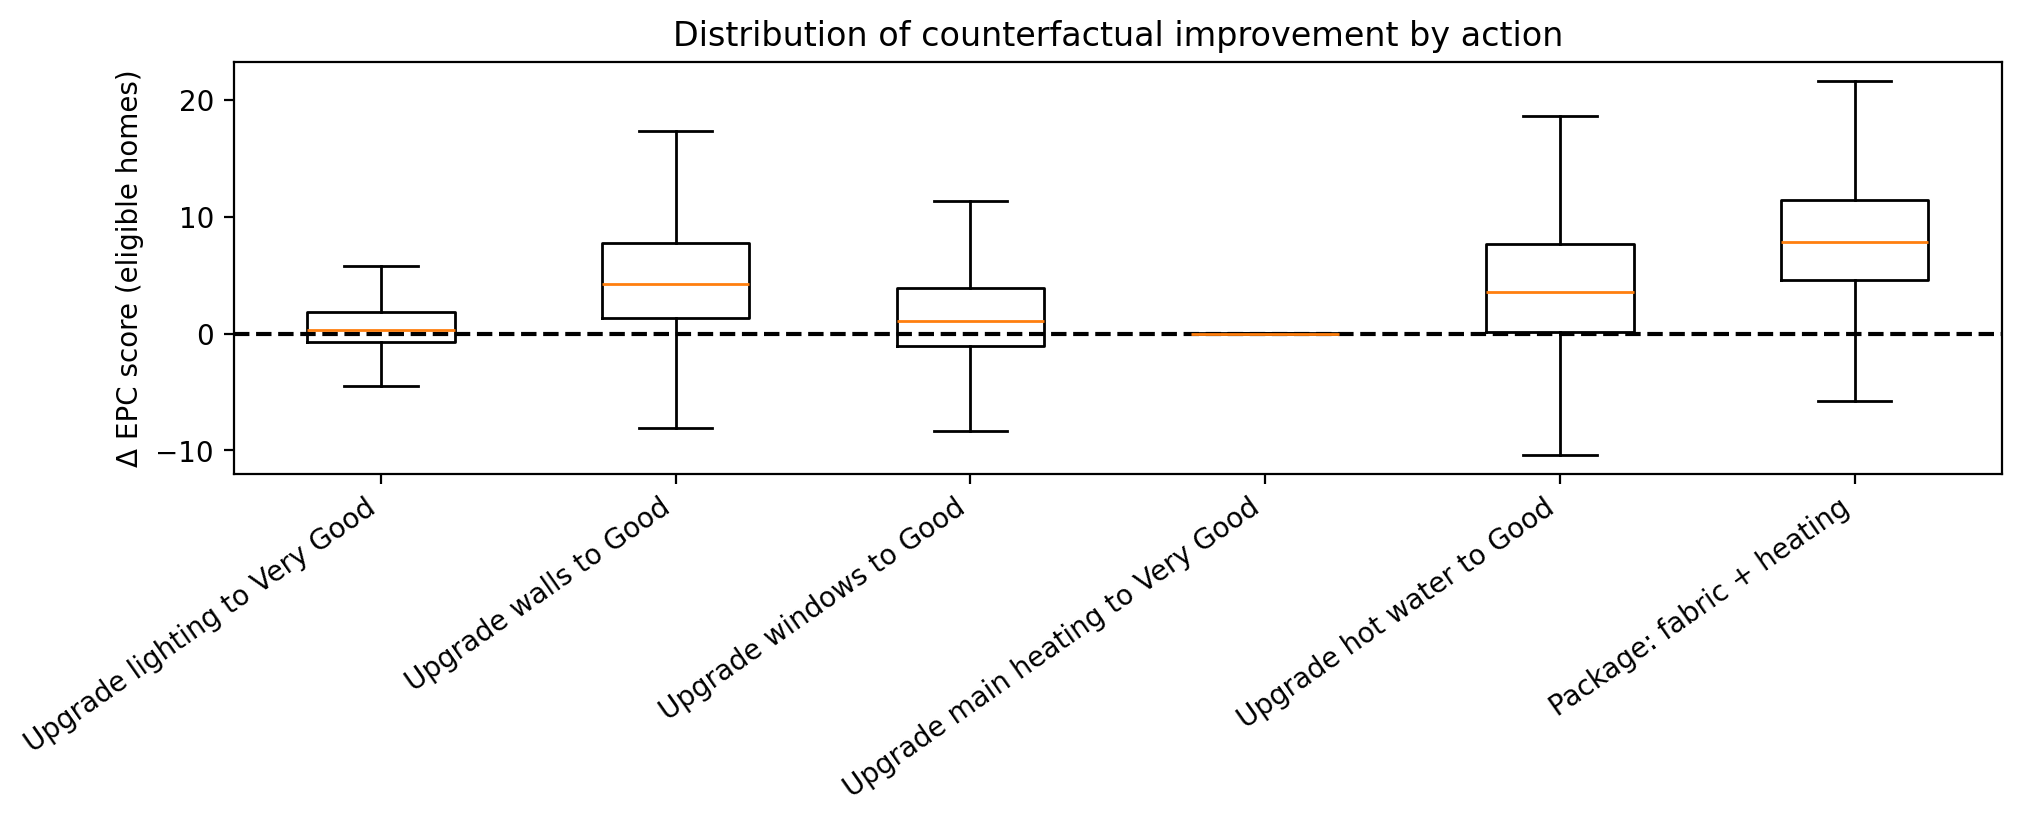

In [7]:
# Filter to actions with eligible homes
plot_actions = [a for a in actions.keys() if len(per_action_deltas[a]) > 0]

means = [np.mean(per_action_deltas[a]) for a in plot_actions]
counts = [len(per_action_deltas[a]) for a in plot_actions]

# Bar chart: mean delta
plt.figure(figsize=(10, 4.5))
plt.bar(range(len(plot_actions)), means)
plt.xticks(range(len(plot_actions)), plot_actions, rotation=35, ha='right')
plt.ylabel("Mean Δ EPC score (eligible homes)")
plt.title("Average counterfactual improvement by action")

# Annotate eligible counts
for i, c in enumerate(counts):
    plt.text(i, means[i], f"n={c}", ha='center', va='bottom', fontsize=8)

plt.show()

# Boxplot: distributions
plt.figure(figsize=(10, 4))
plt.boxplot([per_action_deltas[a] for a in plot_actions], labels=plot_actions, showfliers=False)
plt.xticks(rotation=35, ha='right')
plt.ylabel("Δ EPC score (eligible homes)")
plt.title("Distribution of counterfactual improvement by action")
plt.axhline(0, linestyle='--', color='black')
plt.show()


## Optional: segment impacts by built form

A useful next step is to see whether an action benefits some housing types more than others (e.g., flats vs terraces).


In [8]:
# Example segmentation for one action
example_action = "Upgrade walls to Good"
changes = actions[example_action]

X_cf = test_X.copy()
eligible_mask = np.ones(len(X_cf), dtype=bool)
for feat, target_level in changes.items():
    X_cf, elig = upgrade_to_level(X_cf, feat, target_level)
    eligible_mask &= elig.values

baseline = baseline_pred
cf = model.predict(X_cf)
delta = cf - baseline

seg = pd.DataFrame({
    "BUILT_FORM": test_X["BUILT_FORM"].values,
    "delta": delta,
    "eligible": eligible_mask,
})

seg = seg[seg["eligible"]]
summary = seg.groupby("BUILT_FORM")["delta"].agg(["count", "mean", "median"]).sort_values("mean", ascending=False)
display(summary)


,count,mean,median
BUILT_FORM,,,
End-Terrace,87,7.386110,7.1640
Mid-Terrace,324,6.495129,6.2536
Enclosed Mid-Terrace,12,6.375774,5.4910
Enclosed End-Terrace,4,6.363375,6.8940
Detached,6,5.568405,6.9520
Semi-Detached,47,5.413837,5.4980
Not Recorded,674,3.829079,3.1710
